# TMA4212 - Numerical solution of differential equations by difference methods
## Project 1
Aksel Stenvold, Casper Lindeman, Gonchigsuren Bor

In [61]:
#libraries used for the project
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import pandas as pd  
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

### 1. Developping a code based on the theoretical scheme

In [62]:
'''''
The purpose of the function grid is to discretize the grid we are working with. It takes in
    - bvp: a class with the boundary value problem
and returns
    - h: step size on the x-axis
    - k: step size on the y-axis
    - coord: coordinates on x- and y-axis
    - shape: length of the x- and y-axis, that is (M,N)
'''''

def grid(bvp): 
        
    x = np.linspace(0, 1, bvp.M)
    y = np.linspace(0, 1, bvp.N)
    
    h=x[1]-x[0] 
    k=y[1]-y[0] 
    
    shape = [len(x), len(y)]
    x, y = np.meshgrid(x, y)
    x, y = x.flatten(), y.flatten()
    
    coord = np.zeros((x.size,2))
    coord[:,0]=x
    coord[:,1]=y
    
    return h, k, coord, shape

In [63]:
'''''
We define a class BVP (boundary value problem) for an easier access to the functions for the right-hand side, the boundary conditions and the
number of steps in x- and y-directions.
'''''
class BVP(object): 
    def __init__(self, f, g=0, M=10, N=10):
        #fight-hand side (function)
        self.f = f
        #boundary conditions (function)
        self.g = g
        #number of subdivisions along x-axis (total number of points, including boundaries)
        self.M = M + 1
        #number of subdivisions along y-axis (total number of points, including boundaries)
        self.N = N + 1


In [64]:
#global variables
a = 2   #constant
M = 100  #number of subdivisions along x-axis
N = 100  #number of subdivisions along y-axis

In [65]:
'''''
The function below solves the problem of heat distribution in anisotropic materials with the given boundary values, the function f for the RHS
and number of steps in x- and y-directions using the scheme that we have developped in the report. It takes in 
    -bvp: a class with the boundary value problem
and returns
    - U: a numerical solution to the given problem
    - coord: coordinates on x- and y-axis
'''''

def solve_bvp(bvp):
    h, k, coord, shape = grid(bvp)
    b = np.zeros(len(coord[:,1]))
    b += bvp.f(coord[:,0], coord[:,1])  # Forcing term
    
    #initializing A with the Laplacian operator for internal points
    diag = np.diag([2*a+2]*len(b))
    diag_m_plus_1 = np.diag([-1]*(len(b)-(bvp.M+1)), bvp.M+1) + np.diag([-1]*(len(b)-(bvp.M+1)), -(bvp.M+1))
    diag_plus_1 = np.diag([-a]*(len(b)-1), 1) + np.diag([-a]*(len(b)-1), -1)
    A = (diag + diag_m_plus_1 + diag_plus_1)/(k**2)
    
    #adjusting A and b for boundary conditions
    
    for i in range(bvp.M * bvp.N):
        x, y = coord[i, 0], coord[i, 1]
        if x == 0 or x == 1 or y == 0 or y == 1:  #checking if (x, y) is on the boundary
            A[i, :] = 0
            A[i, i] = 1         #ensures solution at boundary is set by b
            b[i] = bvp.g(x, y)  #set a boundary value in b
    
   
    U = np.linalg.solve(A, b)
    U = np.reshape(U, -1)

    return U, coord


### Testing the code

In [66]:
'''''
Here we define the functions for the BVP-class to test our scheme and consequently our BVP-solver. 
'''''
#RHS
def f(x,y):
    return  -((a+1)*2*np.cos(5*y)-20*x*np.sin(5*y)-25*x**2*np.cos(5*y))

#boundary conditions
def g(x,y):
    return x**2*np.cos(5*y)

#exact solution
def u(x,y):
    return x**2*np.cos(5*y)

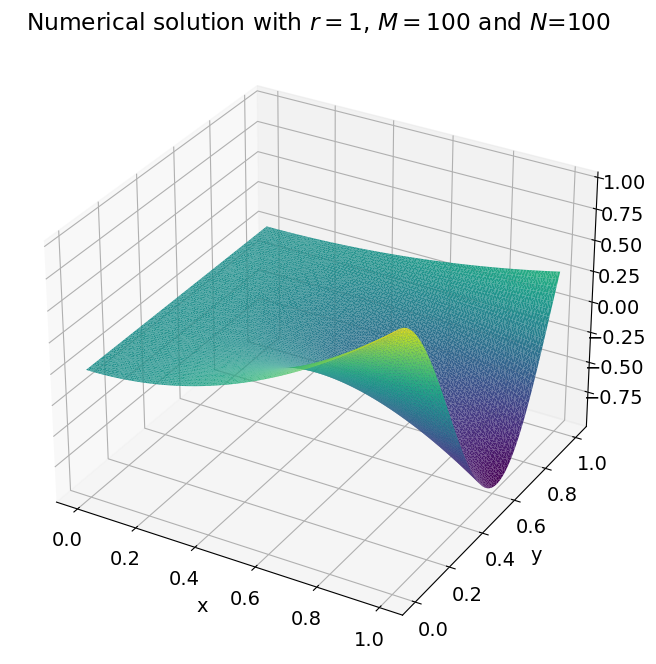

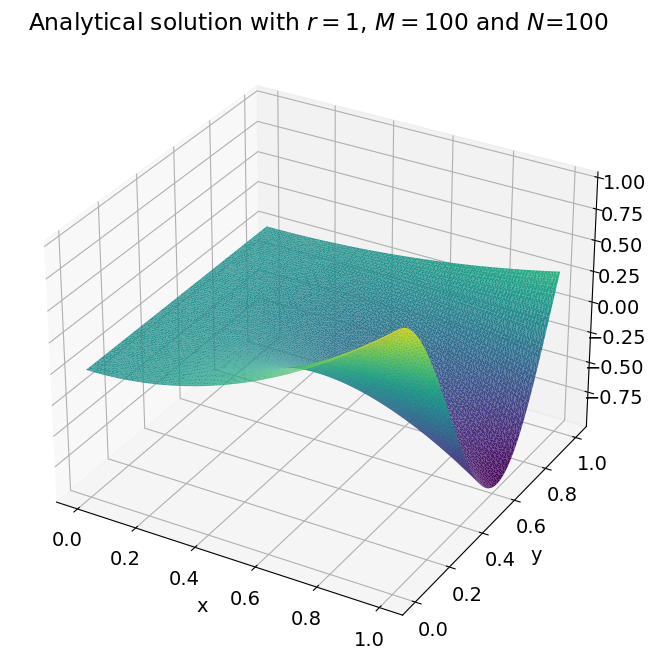

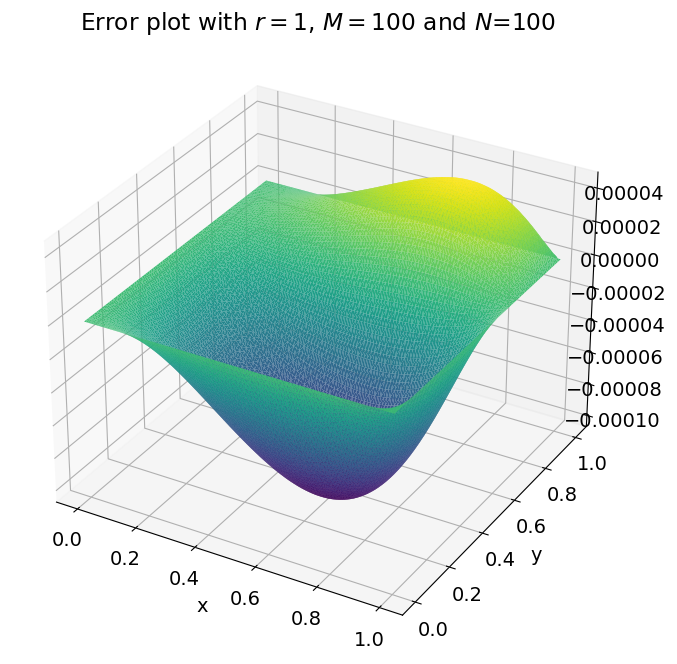

In [67]:
ex1 = BVP(f,g,M,N)
U, coord = solve_bvp(ex1)

plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], U, cmap='viridis', edgecolor='none')
plt.xlabel('x')
plt.ylabel('y')
plt.title(fr"Numerical solution with $r=1$, $M=${M} and $N$={N}")
plt.show()

plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], u(coord[:,0],coord[:,1]),cmap='viridis', edgecolor='none')
plt.xlabel('x')
plt.ylabel('y')
plt.title(fr"Analytical solution with $r=1$, $M=${M} and $N$={N}")
plt.show()

plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], u(coord[:,0],coord[:,1])-U,cmap='viridis', edgecolor='none')
plt.xlabel('x')
plt.ylabel('y')
plt.title(fr"Error plot with $r=1$, $M=${M} and $N$={N}")
plt.show()



### 1.3 Convergence rate, error table and plots of the solution and error plots

In [68]:
'''''
The function below tests the convergence rate of the scheme with different numbers of steps in x- and y- directions. It takes in
    - bvp: a class with the boundary value problem
    - u_exact: an array with the exact solution to the BVP
    - solver: a function that solves the BVP. Default=solve_bvp
and returns:
    - Hconv: step-size h for its correspinding M
    - Emax: maximum error for its corresponding M
    - orderMax: order of convergence for its corresponding M
'''''

def convergence(bvp, u_exact, solver=solve_bvp): 
    P = 4
    M = 5   #number of steps on the x-axis

    Hconv = np.zeros(P) 
    Emax = np.zeros(P)

    for p in range(P):
        bvp = BVP(f,g,M,M)
        U, coord = solve_bvp(bvp)
        Emax[p] = np.max(np.abs(u_exact(coord[:,0],coord[:,1])-U))
        Hconv[p] = coord[1,0]-coord[0,0]
        M = 2*M

    orderMax = np.polyfit(np.log(Hconv),np.log(Emax),1)[0]
    return Hconv, Emax, orderMax

In [69]:
#getting the values for the table of errors and convergence rates
H, EM, pM = convergence(ex1, u)
Rate=np.zeros(np.size(EM))
Rate[1:]=np.log10(EM[1:]/EM[:-1])/np.log10(H[1:]/H[:-1])

#creating table using pandas
pd.options.display.float_format = '{:.5f}'.format
df = pd.DataFrame(data={'h': H, 'Error': EM ,'Rate':Rate}) 
df


,h,Error,Rate
0,0.20000,0.04189,0.00000
1,0.10000,0.01032,2.02139
2,0.05000,0.00260,1.98662
3,0.02500,0.00065,2.00337


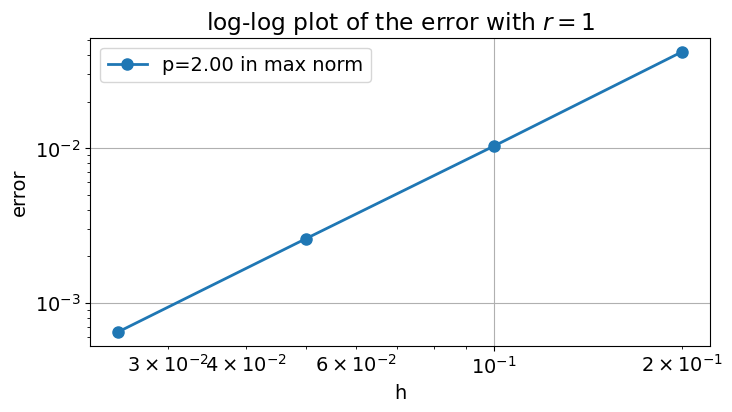

In [70]:
#plot of the log-log error for different step sizes h
plt.figure()
plt.loglog(H,EM,'o-', label='p={:.2f} in max norm'.format(pM))
plt.grid('on')
plt.title('log-log plot of the error with $r=1$')
plt.xlabel('h')
plt.ylabel('error')
plt.legend()
plt.show()

### 1.4 Introducing new step sizes in x- and y-directions

In [71]:
'''''
Since we are now working with different step sizes in x- and y directions, we have to change our grid. The function grid_r is an updated version of the function grid. It takes in
    - bvp: a class with the boundary value problem
    - r: an irrational number
and returns
    - h: step size on the x-axis
    - k: step size on the y-axis
    - coord: coordinates on x- and y-axis
    - shape: length of the x- and y-axis, that is (M,N)
    - y_N: furthest grid point on y-directions that still is within the [0,1^2 boundary 
'''''

def grid_r(bvp,r): 
        
    x = np.linspace(0, 1, bvp.M)
    
    h = x[1] - x[0] 
    k = r*h
    N = math.ceil(1/k) + 1
    y = np.linspace(0,(N-1)*k,N)

    shape = [len(x), len(y)]
    x, y = np.meshgrid(x, y)
    x, y = x.flatten(), y.flatten()
    
    coord = np.zeros((x.size,2))
    coord[:,0]=x
    coord[:,1]=y
    
    y_N = (N-1)*k

    return h, k, coord, shape, y_N

In [72]:
'''''
The function solve_bvp_r is our updated solver that is based on the previous BVP solver. It takes in 
    - bvp: a class with the boundary value problem
    - r: an irrational number
and returns:
    - U: a numerical solution to the given problem
    - coord: coordinates on x- and y-axis
'''''

def solve_bvp_r(bvp,r):
    h, k, coord, shape, y_N = grid_r(bvp,r)
    b = np.zeros(len(coord[:,1]))
    b += bvp.f(coord[:,0], coord[:,1]) 
    
    #initializing A 
    diag = np.diag([2*a+2]*len(b))
    diag_m_plus_1 = np.diag([-1]*(len(b)-(bvp.M+1)), bvp.M+1) + np.diag([-1]*(len(b)-(bvp.M+1)), -(bvp.M+1))
    diag_plus_1 = np.diag([-a]*(len(b)-1), 1) + np.diag([-a]*(len(b)-1), -1)
    A = (diag + diag_m_plus_1 + diag_plus_1)/(h**2)
    
    #adjusting A and b for boundary conditions
    for i in range(len(coord)):
        x, y = coord[i, 0], coord[i, 1]
        if x == 0 or x == 1 or y == 0 or y == y_N:  #checking if the point (x, y) is on the boundary
            A[i, :] = 0
            A[i, i] = 1  #ensures that the solution at boundary is set by b
            if y == y_N:
                b[i] = bvp.g(x, 1)
            else:
                b[i] = bvp.g(x, y)
   
    U = np.linalg.solve(A, b)
    U = np.reshape(U, -1)

    #restoring the boundary
    for i,u in enumerate(U[-bvp.M:]):
        coord[-i-1][1] = 1
        U[-i-1] = bvp.g(coord[-i-1][0],1)
  
    return U, coord


In [73]:
r = np.pi

#RHS
def f(x,y):
    return  -((a+1)*2*np.cos(5*y)-(2*r)*10*x*np.sin(5*y)-(r**2)*25*x**2*np.cos(5*y))

#boundary condition
def g(x,y):
    return x**2*np.cos(5*y)

#exact solution
def u(x,y):
    return x**2*np.cos(5*y)

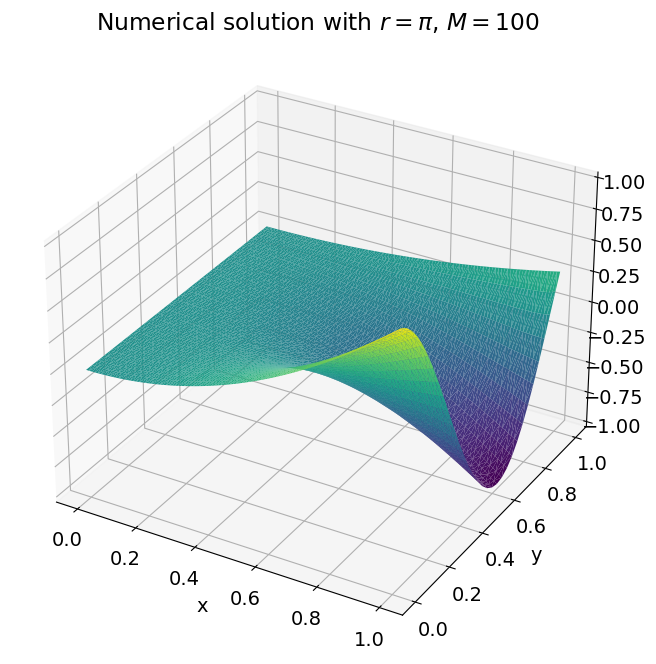

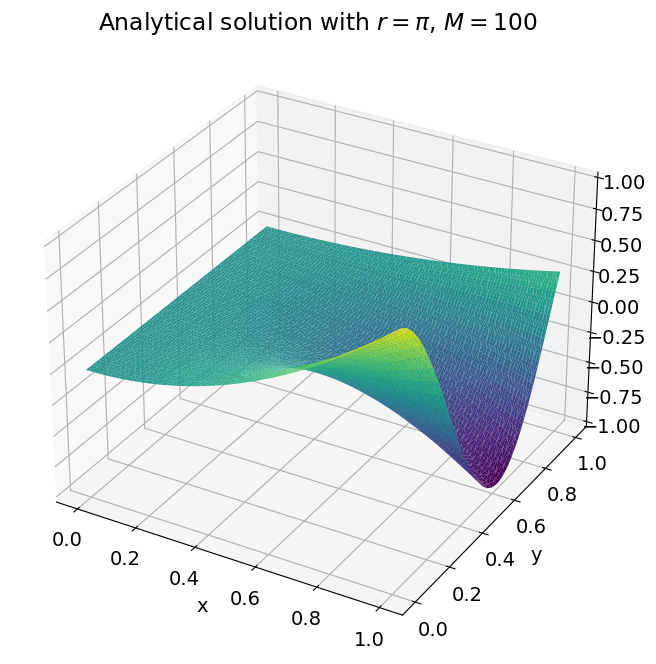

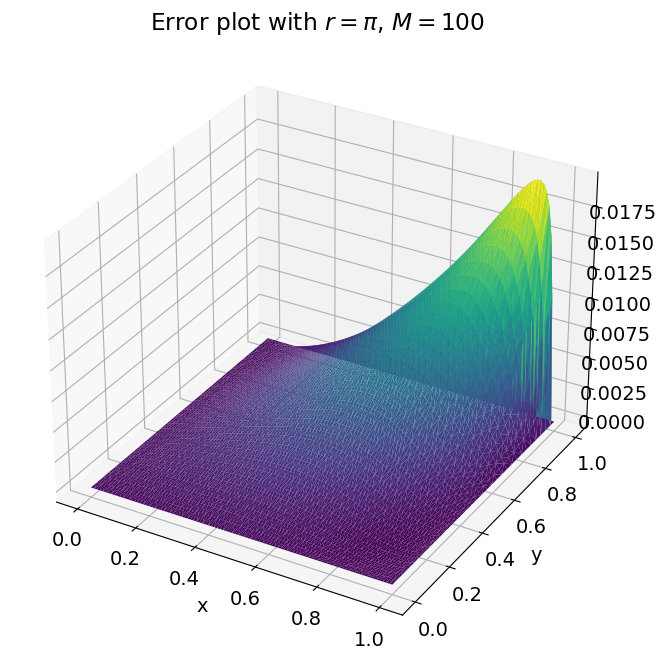

max. error: 0.01983353398204364


In [74]:
#solving the BVP with r=pi

ex1 = BVP(f,g,M,N)
U, coord = solve_bvp_r(ex1,r)

#plot of the numerical solution
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], U, cmap='viridis', edgecolor='none')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Numerical solution with $r=\pi$, $M=${M}')
plt.show()

#plot of the analytical solution
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], u(coord[:,0],coord[:,1]),cmap='viridis', edgecolor='none')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f"Analytical solution with $r=\pi$, $M=${M}")
plt.show()

#error plot
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], u(coord[:,0],coord[:,1])-U,cmap='viridis', edgecolor='none')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f"Error plot with $r=\pi$, $M=${M}")
plt.show()

print(f"max. error: {np.max(np.abs(u(coord[:,0],coord[:,1])-U))}")

In [75]:
'''''
The function below tests the convergence rate of the scheme with different numbers of steps in x- and y- directions. It takes in
    - bvp: a class with the boundary value problem
    - u_exact: an array with the exact solution to the BVP
    - solver: a function that solves the BVP. Default=solve_bvp
and returns:
    - Hconv: step-size h for its correspinding M
    - Emax: maximum error for its corresponding M
    - orderMax: order of convergence for its corresponding M
'''''

def convergence_r(bvp, u_exact, solver=solve_bvp_r): 
    P = 5
    Hconv = np.zeros(P)
    Emax = np.zeros(P)
    M = 4
    
    for p in range(P):
        bvp = BVP(f,g,M,M)
        U, coord = solve_bvp_r(bvp,r)
        Emax[p] = np.max(np.abs(u_exact(coord[:,0],coord[:,1])-U))
        Hconv[p] = coord[1,0]-coord[0,0]
        M = M*2
    orderMax = np.polyfit(np.log(Hconv),np.log(Emax),1)[0]
    return Hconv, Emax, orderMax

In [76]:
# Plot of the convergence plot
H, EM, pM = convergence_r(ex1, u)
Rate=np.zeros(np.size(EM))
Rate[1:]=np.log10(EM[1:]/EM[:-1])/np.log10(H[1:]/H[:-1])

pd.options.display.float_format = '{:.5f}'.format
df = pd.DataFrame(data={'h': H, 'Error': EM ,'Rate':Rate}) 
df


,h,Error,Rate
0,0.25000,1.56834,0.00000
1,0.12500,0.51511,1.60627
2,0.06250,0.35670,0.53016
3,0.03125,0.22340,0.67512
4,0.01562,0.10455,1.09536


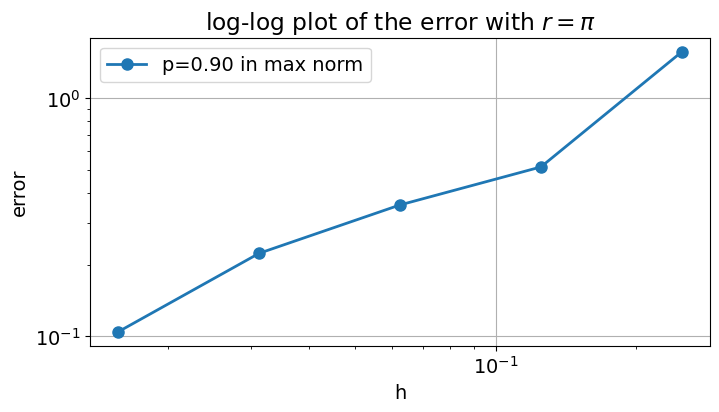

In [77]:
plt.figure()
plt.loglog(H,EM,'o-', label='p={:.2f} in max norm'.format(pM))
plt.grid('on')
plt.title('log-log plot of the error with $r=\pi$')
plt.xlabel('h')
plt.ylabel('error')
plt.legend()
plt.show()

### 2. A different domain $\Omega$

In [78]:
#Below, one can find useful functions for part 2

'''''
Here we define new functions for the BVP-class to test our scheme and consequently our BVP-solver. 
'''''
#RHS. NB.:THIS RHS function is different from the that we used in part 1
def f(x,y):
    return  -2*np.cos(5*y)+25*x**2*np.cos(5*y)

#boundary conditions
def g(x,y):
    return x**2*np.cos(5*y)

#exact solution
def u(x,y):
    return x**2*np.cos(5*y)

#given function h(x)
def h(x):
    return (1/2)*(np.cos(np.pi*x)+1)

ex2 = BVP(f,g,M,M)

In [79]:
'''''
The function below checks whether a given point is inside the domain. It takes in:
    - point: a point with coordinates (x,y=func(x))
    - func: a function that describes the boundary of the domain
and returns
    - True: if the point is within the domain
    _ or False otherwise
'''''

def in_domain(point,func):
    if point[1] < func(point[0]):
        return True
    else:
        return False

### 2.1 Modifying the discretisation near the boundary (MTD)

In [80]:
'''''
The function below solves the BVP by modifying the discretisation near the boundary
    - bvp: a class with the boundary value problem
    - func: a function that restricts the domain
and returns
    - U: a numerical solution to the given problem
    - coord: coordinates on x- and y-axis
'''''

def solve_bvp_modify_discretisation(bvp, func):
    h, k, coord, shape = grid(bvp)
    b = np.zeros(len(coord[:,1]))
    b += bvp.f(coord[:,0], coord[:,1])  #forcing term

    #initialising A with the Laplacian operator for internal points
    diag = np.diag([4]*len(b))
    diag_m_plus_1 = np.diag([-1]*(len(b)-(bvp.M)), bvp.M) + np.diag([-1]*(len(b)-(bvp.M)), -(bvp.M))
    diag_plus_1 = np.diag([-1]*(len(b)-1), 1) + np.diag([-1]*(len(b)-1), -1)
    A = (diag + diag_m_plus_1 + diag_plus_1)/(k**2)
    
    #adjusting A and b for boundary conditions
    
    for i in range((bvp.M) * (bvp.N)):
        x, y = coord[i, 0], coord[i, 1]
        
        if y < func(x) and y >= func(x+h):
            A[i+1,:] = 0
            A[i+1, i+1] = 1
            x_new = fsolve(lambda x_: func(x_)-y,x)[0]
            b[i+1] = bvp.g(x_new,func(x_new))
            
            eta_x = (x_new-x)/h
        
            A[i, i] = (2/eta_x)/h**2 + 2/(h**2)
            A[i, i-1] = -(2/(eta_x+1))/h**2
            A[i, i+1] = -(2/(eta_x*(eta_x+1)))/h**2
            
       
        if y < func(x) and y+h >= func(x):
            A[i+bvp.M,:] = 0
            A[i+bvp.M,i+bvp.M] = 1
            b[i+bvp.M] = bvp.g(x,func(x))
            
            eta_y = (func(x)-y)/k
                
            A[i, i] = (2/eta_y)/k**2 + 2/(k**2)
            A[i, i-bvp.M] = -(2/(eta_y+1))/k**2
            A[i, i+bvp.M] = -(2/(eta_y*(eta_y+1)))/k**2
            
        if y < func(x) and y >= func(x+h) and y < func(x) and y+h >= func(x):
            
            A[i, i] = (2/eta_y)/k**2 + (2/eta_x)/h**2 
            A[i, i-1] = -(2/(eta_x+1))/h**2
            A[i, i+1] = -(2/(eta_x*(eta_x+1)))/h**2
            A[i, i-bvp.M] = -(2/(eta_y+1))/k**2
            A[i, i+bvp.M] = -(2/(eta_y*(eta_y+1)))/k**2
            
            
        if x == 0 or y == 0:  #checking if (x, y) is on the boundary
            A[i, :] = 0
            A[i, i] = 1  #ensures solution at boundary is set by b
            b[i] = bvp.g(x, y)  #setting boundary value in b
        
    U = np.linalg.solve(A, b)
    U = np.reshape(U, -1)
    
    for i in range(len(coord)):
        if not in_domain(coord[i],func):
            U[i] = 0
            
    return U, coord

In [81]:
'''''
The function below tests the convergence rate of the new scheme with different numbers of steps in x- and y- directions. It takes in
    - bvp: a class with the boundary value problem
    - u_exact: an array with the exact solution to the BVP
    - solver: a function that solves the BVP. Default=solve_bvp
    - func: a function that restrict the domain. Default=h
and returns:
    - Hconv: step-size h for its correspinding M
    - Emax: maximum error for its corresponding M
    - orderMax: order of convergence for its corresponding M
'''''

def convergence_2(bvp, u_exact, solver=solve_bvp_modify_discretisation, func=h): 
    P = 4
    M = 10

    Hconv = np.zeros(P)
    Emax = np.zeros(P)

    for p in range(P):
        bvp = BVP(f,g,M,M)
        U, coord = solver(bvp,func)
        
        analytic = u(coord[:,0],coord[:,1])

        for i in range(len(coord)):
            if not in_domain(coord[i],func):
                analytic[i] = 0
        
        Emax[p] = np.max(np.abs(analytic-U))
        Hconv[p] = coord[1,0]-coord[0,0]
        M = M*2
    orderMax = np.polyfit(np.log(Hconv),np.log(Emax),1)[0]
    return Hconv, Emax, orderMax

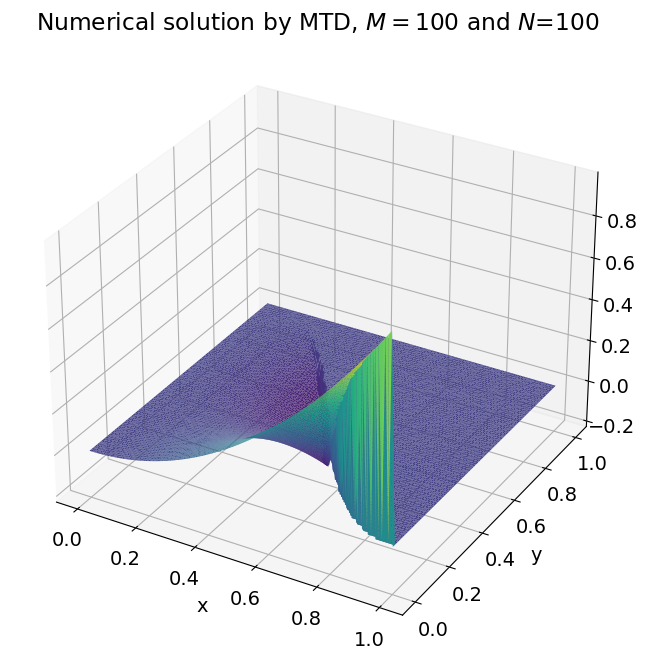

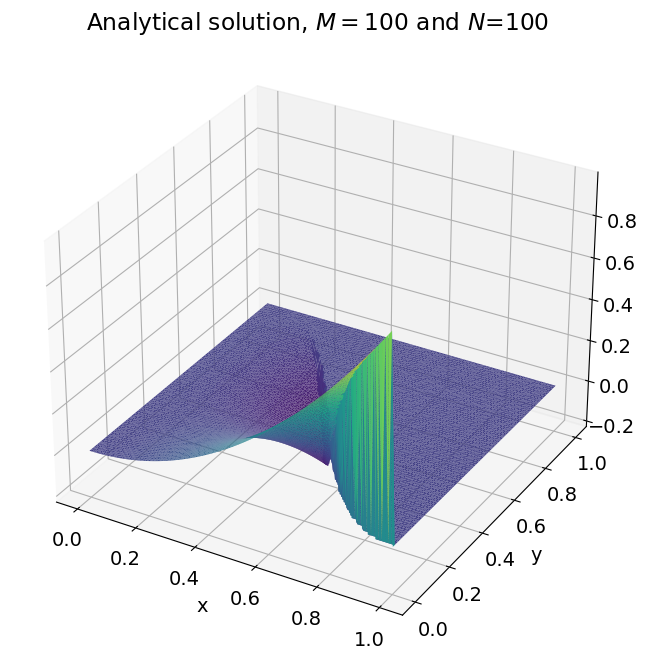

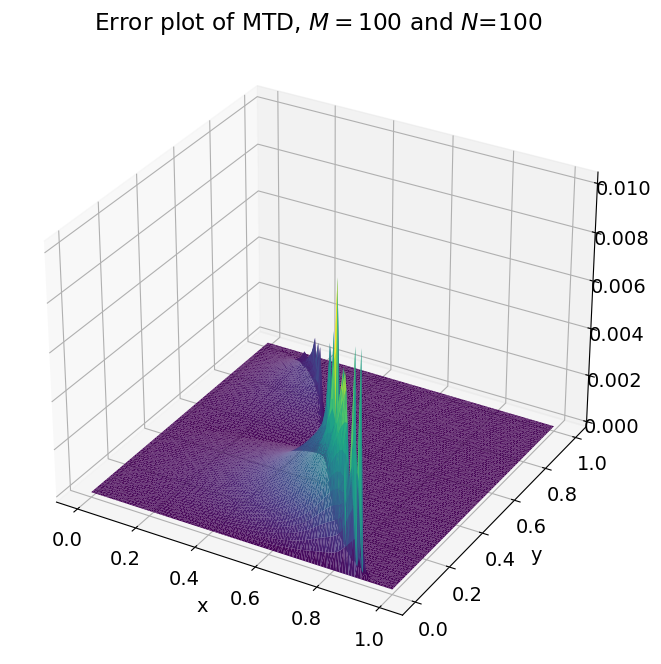

In [82]:
U_modify_discr, coord = solve_bvp_modify_discretisation(ex2,h)
analytic = u(coord[:,0],coord[:,1])

for i in range(len(coord)):
    if not in_domain(coord[i],h):
        analytic[i] = 0


#plotting the solution
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], U_modify_discr, cmap='viridis', edgecolor='none')
plt.xlabel('x')
plt.ylabel('y')
plt.title(fr"Numerical solution by MTD, $M=${M} and $N$={N}")
plt.show()

#plotting the analytic solution
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], analytic,cmap='viridis', edgecolor='none')
plt.xlabel('x')
plt.ylabel('y')
plt.title(fr"Analytical solution, $M=${M} and $N$={N}")
plt.show()

#plotting the error
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], np.abs(analytic-U_modify_discr),cmap='viridis', edgecolor='none')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f"Error plot of MTD, $M=${M} and $N$={N}")
plt.show()

In [83]:
#getting the values for the table of errors and convergence rates
H, EM, pM = convergence_2(ex1,u,solve_bvp_modify_discretisation)
Rate=np.zeros(np.size(EM))
Rate[1:]=np.log10(EM[1:]/EM[:-1])/np.log10(H[1:]/H[:-1])
pd.options.display.float_format = '{:.5f}'.format
df = pd.DataFrame(data={'h': H, 'Error': EM ,'Rate':Rate}) 
df

,h,Error,Rate
0,0.10000,0.09513,0.00000
1,0.05000,0.04611,1.04477
2,0.02500,0.03079,0.58264
3,0.01250,0.01529,1.01012


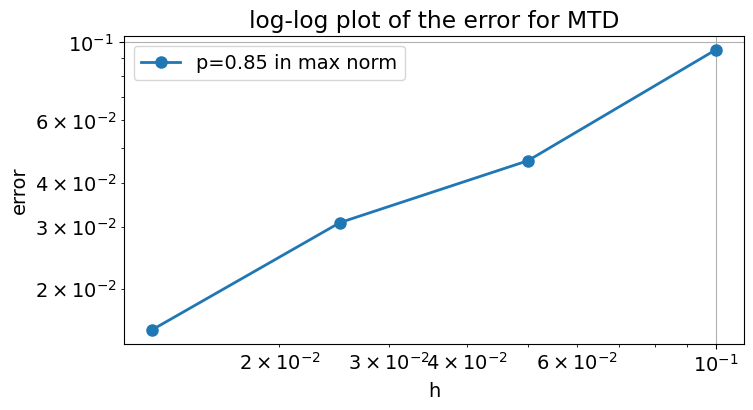

In [84]:
#plot of the log-log error for different step sizes h
plt.figure()
plt.loglog(H,EM,'o-', label='p={:.2f} in max norm'.format(pM))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title('log-log plot of the error for MTD')
plt.legend()
plt.show()

### 2.2 Fattening the boundaries (FTB)

In [85]:
'''''
The function below solves the BVP by fattening the boundaries
    - bvp: a class with the boundary value problem
    - func: a function that restricts the domain
and returns
    - U: a numerical solution to the given problem
    - coord: coordinates on x- and y-axis
'''''

def solve_bvp_fatten_bdry(bvp, func): 
    h, k, coord, shape = grid(bvp)
    b = np.zeros(len(coord[:,1]))
    b += bvp.f(coord[:,0], coord[:,1])  #forcing term
    
    #initializing A with the Laplacian operator for internal points
    diag = np.diag([4]*len(b))
    diag_m_plus_1 = np.diag([-1]*(len(b)-(bvp.M)), bvp.M) + np.diag([-1]*(len(b)-(bvp.M)), -(bvp.M))
    diag_plus_1 = np.diag([-1]*(len(b)-1), 1) + np.diag([-1]*(len(b)-1), -1)
    A = (diag + diag_m_plus_1 + diag_plus_1)/(k**2)

    #adjusting A and b for boundary conditions
    for i in range(bvp.M * bvp.N):
        x, y = coord[i, 0], coord[i, 1]
        if x == 0 or x == 1 or y == 0 or y == 1:  #checking if (x, y) is on the boundary
            A[i, :] = 0
            A[i, i] = 1  #ensuring that the solution at boundary is set by b
            b[i] = bvp.g(x, y)  #setting boundary value in b
        if not in_domain(coord[i],func) and in_domain(coord[i-1],func):
            A[i,:] = 0
            A[i,i] = 1  #ensuring that the solution at boundary is set by b
            x_n = fsolve(lambda x_new: func(x_new)-y,x)[0]
            b[i] = bvp.g(x_n, y)  #setting boundary value in b
        if not in_domain(coord[i],func) and in_domain(coord[i-bvp.M],func):
            A[i,:] = 0
            A[i,i] = 1  #ensuring that the solution at boundary is set by b
            b[i] = bvp.g(x, func(x))  #setting boundary value in b
        
    U = np.linalg.solve(A, b)
    U = np.reshape(U, -1)
    
    for i in range(len(coord)):
        if not in_domain(coord[i],func):
            U[i] = 0
            

    return U, coord

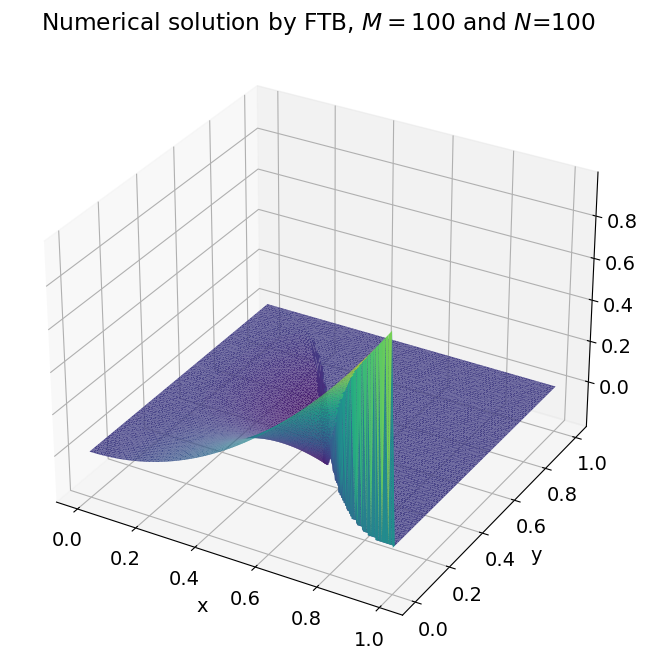

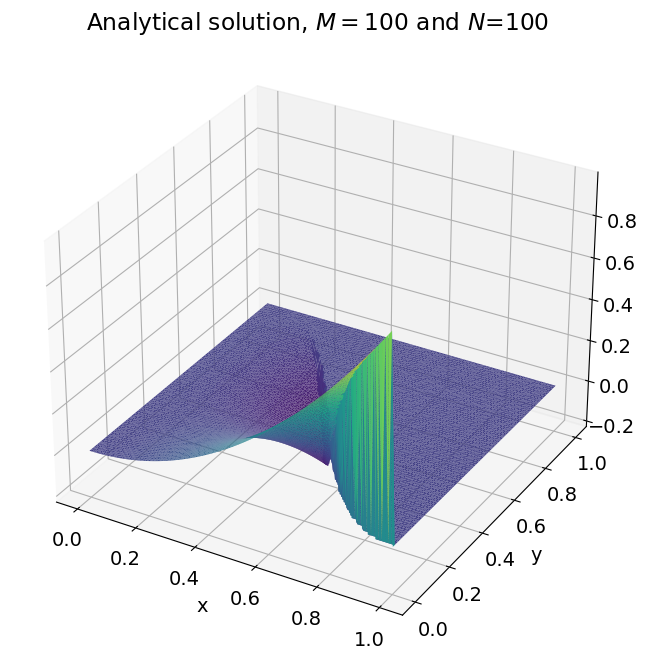

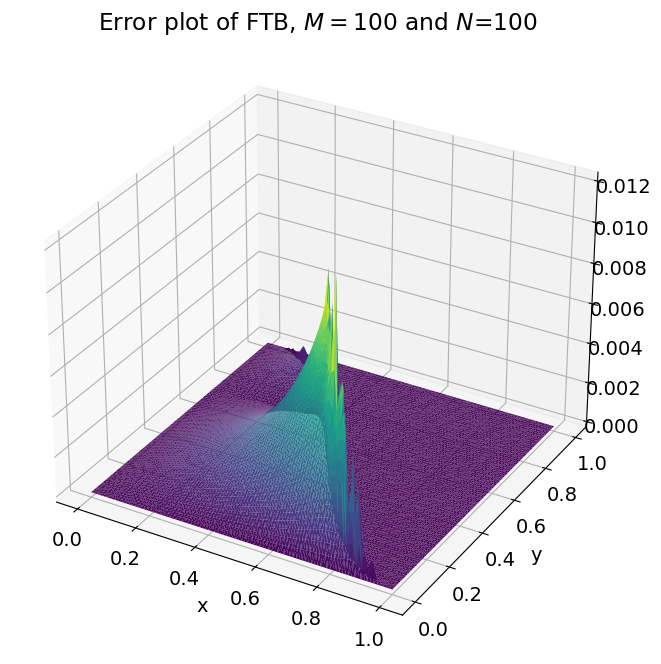

In [86]:
M = 100
U_fatten_bdry, coord = solve_bvp_fatten_bdry(ex2,h)
analytic = u(coord[:,0],coord[:,1])

for i in range(len(coord)):
    if not in_domain(coord[i],h):
        analytic[i] = 0

#plot of the numerical solution
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], U_fatten_bdry, cmap='viridis', edgecolor='none')
plt.xlabel('x')
plt.ylabel('y')
plt.title(fr"Numerical solution by FTB, $M=${M} and $N$={N}")
plt.show()

#plot of the analytical solution
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], analytic,cmap='viridis', edgecolor='none')
plt.xlabel('x')
plt.ylabel('y')
plt.title(fr"Analytical solution, $M=${M} and $N$={N}")
plt.show()

plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], np.abs(analytic-U_fatten_bdry),cmap='viridis', edgecolor='none')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f"Error plot of FTB, $M=${M} and $N$={N}")
plt.show()

In [87]:
#getting the values for the table of errors and convergence rates
H, EM, pM = convergence_2(ex1, u, solve_bvp_fatten_bdry)
Rate=np.zeros(np.size(EM))
Rate[1:]=np.log10(EM[1:]/EM[:-1])/np.log10(H[1:]/H[:-1])

#creating table using pandas
pd.options.display.float_format = '{:.5f}'.format
df = pd.DataFrame(data={'h': H, 'Error': EM ,'Rate':Rate}) 
df

,h,Error,Rate
0,0.10000,0.10556,0.00000
1,0.05000,0.05475,0.94707
2,0.02500,0.03474,0.65622
3,0.01250,0.01760,0.98134


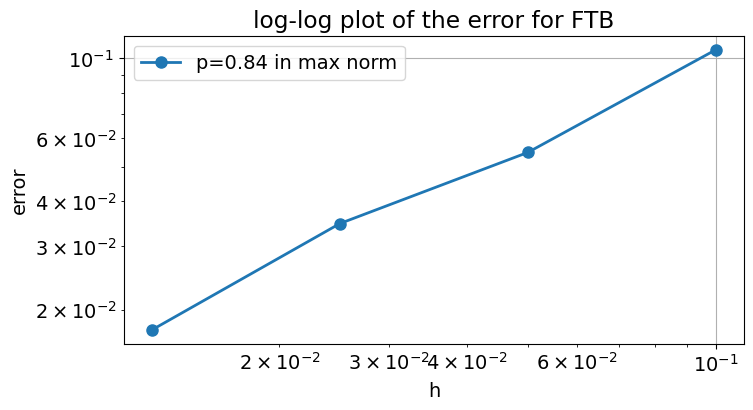

In [88]:
#plot of the log-log error for different step sizes h
plt.figure()
plt.loglog(H,EM,'o-', label='p={:.2f} in max norm'.format(pM))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title('log-log plot of the error for FTB')
plt.legend()
plt.show()